In [2]:
#coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from ncov.reader import get_data,watch_data
## test:
# get_data('湖北', '武汉', '2020-01-01', '2020-02-08')

In [3]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [4]:
import torch
from torch.nn.parameter import Parameter
torch.set_default_tensor_type(torch.DoubleTensor)

In [5]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.5, omega_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_1 = 0.
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        self.omega = Parameter(torch.tensor([omega_init], requires_grad=True))
        # self.omega = 0.


    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def sigmoid(self, X):
        return X

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = self.clamp(S + self.sigmoid(self.omega)*Exposed - self.sigmoid(self.beta)*confirm*S/self.N) # dS/dt
        E = self.clamp(Exposed + self.sigmoid(self.beta)*confirm*S/self.N - (self.sigmoid(self.alpha)+self.sigmoid(self.omega))*Exposed) # dE/dt

        I = self.clamp(confirm + self.sigmoid(self.alpha)*Exposed - (self.sigmoid(self.gamma_2)+ self.sigmoid(self.theta))*confirm) # dI/dt
        R = self.clamp(recover + self.sigmoid(self.gamma_2)*confirm) # dR/dt
        D = self.clamp(dead + self.sigmoid(self.theta)*confirm)

        # I = self.clamp(confirm + self.sigmoid(self.alpha)*E - self.sigmoid(self.gamma_2)*confirm - self.sigmoid(self.theta)*confirm) # dI/dt
        # R = self.clamp(recover + self.sigmoid(self.gamma_2)*I) # dR/dt
        # D = self.clamp(dead + self.sigmoid(self.theta)*I)

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha, self.omega, self.N


In [6]:

class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., I_init=41, R_init=2., D_init=0., E_init=0.):
        super(SEIR_model, self).__init__()
        self.date_len = date_len
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.I = I_init
        self.E = E_init
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len

        for i in range(self.date_len):
            self.SEIR_cells.append(SEIR_cell(self.N))

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur, omega_cur, N = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.omega = omega_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            self.N_cur = N
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, N_cur=0, beta=0, gamma_2=0, theta=0, alpha=0, omega=0):
        if N_cur==0:
            N_cur=self.N_cur
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta
            omega=self.omega
            alpha=self.alpha

        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta,alpha,omega))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_, omega_, N_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor
    
    def param_pred(self, pred_date_len, beta_list, gamma_2_list, theta_list, omega_list):
        pass
    
        

In [7]:
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    # accumulated_confirmed = data[I_name]
    # accumulated_death = data['accumulated_death']
    # accumulated_recovered = data[R_name]
    time_val = data[T_name].values
    
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, accumulated_confirmed, color = 'red', label = '累计确诊人数',marker = 'x')
    plt.plot(merge_time, accumulated_pred_confirmed, color = 'blue',label = '预测的累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [29]:
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '预测新增确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [40]:
def plot_SEIRD(data, S, E, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    for a,b in zip(merge_time, S):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [32]:
import torch.optim as optim
import os
# def loss_fn(pred, gt):
#     T = gt.shape
#     loss = torch.tensor([0.])
#     for i in range(T.data.numpy()):
#         loss = loss + torch.mean((i+1)*torch.pow(pred[i]-gt[i],2))
    # return loss
def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path,city)
    
    model_city_date_path = os.path.join(model_city_path,date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6/2., D_init=1e-6/6., E_init=1e-6, features=['I', 'cured', 'dead', 'E'], max_epoches = 400, lr=0.01, E_loss_ratio=0.025, start_train_E=0):
    model_pt = os.path.join(model_city_date_path,'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat,dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len,  pred_date_len = 10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init)
    # Learning rate for optimizers
    lr = lr
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    # I_pred_list = []
    # R_pred_list = []
    # optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    loss_min = 1e9
    loss_list = []
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S,I,E,R,D, beta,gamma_2 = model(model_inp.float())
        # print(output)
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_E = E
        # print(pred_confirmed)
        
        I_gt_tensor = Input[:,0]
        recovered_gt_tensor = Input[:,1]
        dead_gt_tensor = Input[:,2]
        E_gt_tenor = Input[:,3]

        # loss = torch.sqrt(loss_fn(pred_I, I_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_E, E_gt_tenor))
        loss_C = torch.sqrt(loss_fn(pred_I, I_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor))
        loss_E = torch.sqrt(loss_fn(pred_E, E_gt_tenor))
        # start_train_E=0
        # if epoch_step>=start_train_E:
        loss = (1-E_loss_ratio)*loss_C + E_loss_ratio*loss_E
        print("Loss: {}".format(loss))
        print("Loss E: {}".format(loss_E))
        loss_list.append(loss)
        if loss<loss_min and epoch_step>=start_train_E:
            loss_min = loss
            torch.save(model, model_pt)
        # optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:",loss_min)
    return S,I,E,R,D, loss_list


# model_city_date_path = make_dir('wuhan','02-03')
# features=['accumulated_confirmed', 'accumulated_recovered']
# S,I,E,R,model = train(data_wh_feat, model_city_date_path, N=2870000., I_init=41, R_init=2., features=features, max_epoches=400)

In [33]:
def train_with_city_data(data, N_init, date, cityname='深圳', features=['I', 'cured','dead','E'], max_epoches=2000, start_train_E=1e9):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    E_init = float(data['E'].iloc[0])
    S,I,E,R,D, loss_list = train(data, model_city_date_path, N=N_init, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init, features=features, max_epoches=max_epoches, lr=0.01, E_loss_ratio=0.025, start_train_E=start_train_E)
    # plt
    plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')

    return model_city_date_path

In [34]:
def load_model_predict(model_city_date_path, data, N_cur=0,beta=0,gamma_2=0,theta=0, city_name='深圳',c='confirmed', features=['I','cured','dead','E'], pred_date_len=5):
    I_name,recover_name,dead_name,E_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(N_cur=N_cur,beta=beta,gamma_2=gamma_2,theta=theta, pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)


    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
    plot_SEIRD(data, S_pred_total,E_pred_total,I_pred_total,R_pred_total,D_pred_total,city=city_name, pred_date_len=pred_date_len)
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [11]:
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [156]:
# data_china = pd.read_excel('./ncov/data/nation_data.xlsx')
data_china = read_data('./ncov/data/nation_截至0209_24时.csv')
data_china

,confirmed,new_confirmed,suspected,new_suspected,dead,new_death,cured,new_cured,close_contact,under_medical_observation,quit_medical_observation,time,I,E
0,291,77,54,27,6,6,0,0,1739,922,817,2020-01-20,285,2715
1,440,149,136,82,9,3,0,0,2197,1349,848,2020-01-21,431,3682
2,571,131,393,257,17,8,0,0,5897,4928,969,2020-01-22,554,11218
3,830,259,1072,680,25,8,34,6,9507,8420,1087,2020-01-23,771,18999
4,1287,444,1965,1118,41,16,38,3,15197,13967,1230,2020-01-24,1208,31129
5,1975,688,2684,1309,56,15,49,11,23431,21556,1875,2020-01-25,1870,47671
6,2744,769,5794,3806,80,24,51,2,32799,30453,2346,2020-01-26,2613,69046
7,4515,1771,6973,2077,106,26,60,9,47833,44132,3701,2020-01-27,4349,98938
8,5974,1459,9239,3248,132,26,103,43,65537,59990,5547,2020-01-28,5739,134766
9,7711,1737,12167,4148,170,38,124,21,88693,81947,6746,2020-01-29,7417,182807


In [159]:
# # data_china['time'] = data_china['time'].apply(lambda x: '2020/'+x.replace('月','/').replace('日',''))
# data_china['time'] = pd.to_datetime(data_china['time'])
# data_china['time']

In [162]:
# data_china['E']=data_china['suspected']+data_china['close_contact']+data_china['under_medical_observation']
# data_china['E']

In [163]:
def train_with_city_data(data, N_init, date, cityname='深圳', features=['I', 'cured','dead','E'], max_epoches=2000, start_train_E=1e9):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    E_init = float(data['E'].iloc[0])
    S,I,E,R,D, loss_list = train(data, model_city_date_path, N=N_init, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init, features=features, max_epoches=max_epoches, lr=0.01, E_loss_ratio=0.025, start_train_E=start_train_E)
    # plt
    plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')

    return model_city_date_path

In [164]:
# E_init = float(max(data_china['E']))
# E_init

695535
Training step:  2723
Loss: 6732.12689947844
Loss E: 237900.7780024046
Training step:  2724
Loss: 13433.883959321589
Loss E: 229979.83830019063
Training step:  2725
Loss: 9770.106173275057
Loss E: 244302.92921275782
Training step:  2726
Loss: 8501.800718414857
Loss E: 233234.81597521744
Training step:  2727
Loss: 11220.641781618215
Loss E: 247434.26879711714
Training step:  2728
Loss: 6249.396061871594
Loss E: 236779.55849461866
Training step:  2729
Loss: 7819.519264418125
Loss E: 239704.02175340842
Training step:  2730
Loss: 11822.233398190794
Loss E: 230271.49911897685
Training step:  2731
Loss: 10119.490219506468
Loss E: 245055.67502489878
Training step:  2732
Loss: 7822.173953766188
Loss E: 234115.21766831496
Training step:  2733
Loss: 11362.956710648896
Loss E: 247404.6144612357
Training step:  2734
Loss: 6276.7619410177085
Loss E: 236927.08002086778
Training step:  2735
Loss: 9224.670205521868
Loss E: 232327.55056079058
Training step:  2736
Loss: 10934.108826842274
Loss E: 

'models/china/tmp'

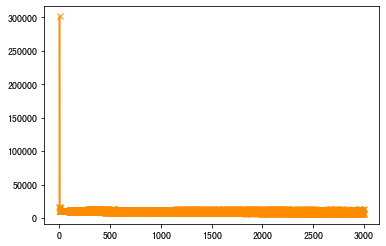

In [136]:
# model_city_date_path = make_dir('china','02-08')
# features=['confirmed', 'cured', 'dead']
# I_init = float(data_china[features[0]].iloc[0])
# R_init = float(data_china[features[1]].iloc[0])
# D_init = float(data_china[features[2]].iloc[0])
# E_init = 
N_init = (max(data_china['E'])+max(data_china['I'])+max(data_china['cured'])+max(data_china['dead']))*100.
date = 'tmp'
cityname='全国'
# S_china,I_china,E_china,R_china,D_china = train(data_china, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)
train_with_city_data(data_china,N_init,date,cityname,max_epoches=3000,start_train_E=0)

In [138]:
model_city_date_path='models/china/tmp'
model_pt = os.path.join(model_city_date_path,'model.pt')
model = torch.load(model_pt)
model.I_tensor_cur

tensor([ 2.8500e+02, -3.9267e-01,  3.8712e+00,  1.6150e+01,  3.4636e+02,
         1.2629e+03,  2.2920e+03,  4.1959e+03,  5.7067e+03,  7.4425e+03,
         9.3717e+03,  1.1346e+04,  1.3799e+04,  1.6421e+04,  1.9434e+04,
         2.3031e+04,  2.6407e+04,  2.9067e+04,  3.1857e+04,  3.3789e+04,
         3.6154e+04], requires_grad=True)

In [139]:
model.E_tensor_cur

tensor([  2715.0000,   2648.2667,   2601.5089,   2788.8591,   2901.0987,
          2723.7867,   2894.6262,   2735.2220,   3764.9177,   5096.5464,
          6987.9366,   9893.4708,  13593.2768,  18899.5827,  26421.8390,
         39535.4833,  70253.6185, 142675.7329, 336895.7194, 493830.7623,
        616259.2861], requires_grad=True)

In [140]:
model.S_tensor_cur

tensor([65073494.0000, 65073815.1982, 65073857.8305, 65073657.1836,
        65073211.3443, 65072402.1111, 65071087.4690, 65069355.1420,
        65066832.4636, 65063682.7231, 65059758.8778, 65054810.3164,
        65048578.8598, 65040484.7494, 65029758.5769, 65012670.8206,
        64978228.1815, 64902749.7868, 64705114.8872, 64545442.9718,
        64418870.7612], requires_grad=True)

In [141]:
model.R_tensor_cur

tensor([   0.0000,   16.1241,   16.0539,   16.5710,   18.2653,   52.5698,
         105.1165,   91.4683,   83.1280,  118.4257,  171.5242,  218.7875,
         278.3086,  406.3781,  548.5507,  834.4858, 1103.1744, 1458.5769,
        1983.1268, 2639.9098, 3788.2782], requires_grad=True)

In [142]:
model.D_tensor_cur

tensor([   6.0000,   20.8037,   20.7355,   21.2367,   22.9337,   58.6614,
         120.8146,  122.2341,  112.7683,  159.8082,  209.9338,  231.4952,
         250.6891,  288.4535,  337.4969,  428.1239,  508.4097,  548.7571,
         648.9657,  797.4743, 1427.4166], requires_grad=True)

In [143]:
param = {'beta_model_3': 0.09111736783585582, 'gamma_2_model_3': 0.016532860820465893, 'N_model_3': 13000000000.106674, 'theta_model_3': 0.006605514213817316}
param = {'beta_model_3': 0.09111736783585582, 'gamma_2_model_3': 0.016532860820465893, 'N_model_3': 0, 'theta_model_3': 0.006605514213817316}
def change_key(param,i):
    for k in list(param.keys()):
        old_key = k
        new_key = k.replace(f'_model_{i}','')
        param[new_key]=param.pop(old_key)
    return param
param = change_key(param,3)
param

{'beta': 0.09111736783585582,
 'gamma_2': 0.016532860820465893,
 'N': 0,
 'theta': 0.006605514213817316}

In [25]:
features=['I', 'cured', 'dead','E']
load_model_predict(model_city_date_path, data_china, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], city_name='全国', features=features)

NameError: name 'data_china' is not defined

In [12]:
def read_hubei_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [13]:
data_hubei = read_data('./ncov/data/hubei_截至0209_24时i.csv')
data_hubei

,confirmed,suspected,dead,cured,close_contact,under_medical_observation,quit_medical_observation,time,I,E
0,270,0,6,25,1070,331,739,2020-01-20,239,1401
1,375,0,9,28,1181,426,755,2020-01-21,338,1607
2,444,0,17,28,2556,1693,863,2020-01-22,399,4249
3,549,0,24,31,3653,2776,877,2020-01-23,494,6429
4,729,0,39,32,5682,4711,971,2020-01-24,658,10393
5,1052,0,52,42,7989,6904,1085,2020-01-25,958,14893
6,1423,0,76,44,10394,9103,1291,2020-01-26,1303,19497
7,2714,0,100,47,16904,15559,1345,2020-01-27,2567,32463
8,3554,0,125,80,22095,20366,1729,2020-01-28,3349,42461
9,4586,0,162,90,28780,26632,2148,2020-01-29,4334,55412


In [14]:
data_hubei['E']

0       1401
1       1607
2       4249
3       6429
4      10393
5      14893
6      19497
7      32463
8      42461
9      55412
10     67484
11     77913
12     91692
13    104259
14    127532
15    147803
16    155124
17    165656
18    181846
19    217903
20    224120
Name: E, dtype: int64

5673457
Loss E: 33442.86492047856
Training step:  5722
Loss: 4470.507822148703
Loss E: 36688.47331552919
Training step:  5723
Loss: 1685.082622913079
Loss E: 37778.68378228993
Training step:  5724
Loss: 4178.441596416318
Loss E: 36438.723424752636
Training step:  5725
Loss: 2100.6688295754966
Loss E: 39507.786301471104
Training step:  5726
Loss: 4299.806163558913
Loss E: 37267.091273409256
Training step:  5727
Loss: 1724.559755929638
Loss E: 35689.69758458124
Training step:  5728
Loss: 3698.5850949674073
Loss E: 43905.02043693903
Training step:  5729
Loss: 2315.6033355784853
Loss E: 33496.61856563323
Training step:  5730
Loss: 4489.864891702348
Loss E: 36536.03612585871
Training step:  5731
Loss: 1678.0164228003641
Loss E: 37871.45004847426
Training step:  5732
Loss: 4131.202929101213
Loss E: 36255.04750283262
Training step:  5733
Loss: 2143.149444866608
Loss E: 39314.48797445133
Training step:  5734
Loss: 4297.817091216525
Loss E: 37248.503605216436
Training step:  5735
Loss: 1721.811

'models/hubei/yisi02-10'

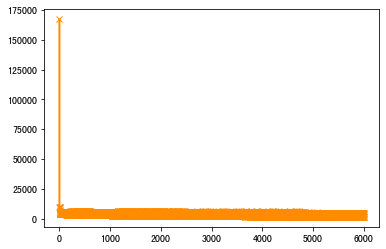

In [26]:
N_init = (max(data_hubei['E'])+max(data_hubei['I'])+max(data_hubei['cured'])+max(data_hubei['dead']))*10000.
date = 'yisi02-10'
cityname='湖北'
# S_china,I_china,E_china,R_china,D_china = train(data_hubei, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)
train_with_city_data(data_hubei,N_init,date,cityname,max_epoches=6000,start_train_E=0)

In [27]:
model_city_date_path='models/hubei/yisi02-10'
model_pt = os.path.join(model_city_date_path,'model.pt')
model = torch.load(model_pt)
model.I_tensor_cur

tensor([2.3900e+02, 1.3032e+00, 1.1151e+01, 3.6945e+01, 1.2350e+02, 5.3755e+02,
        9.2620e+02, 2.5090e+03, 3.3500e+03, 4.3063e+03, 5.4654e+03, 6.7038e+03,
        8.5583e+03, 1.0538e+04, 1.2708e+04, 1.5710e+04, 1.8549e+04, 2.0768e+04,
        2.3283e+04, 2.5108e+04, 2.7351e+04], requires_grad=True)

[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631]


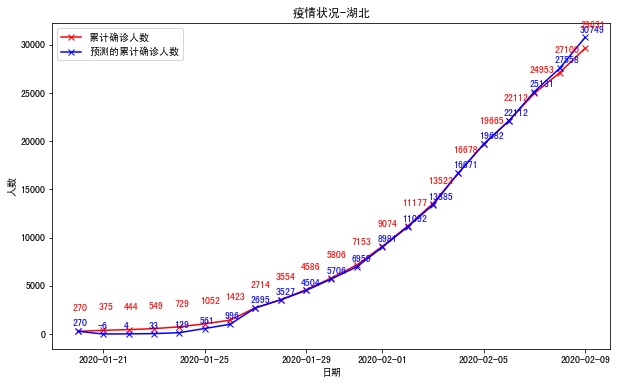

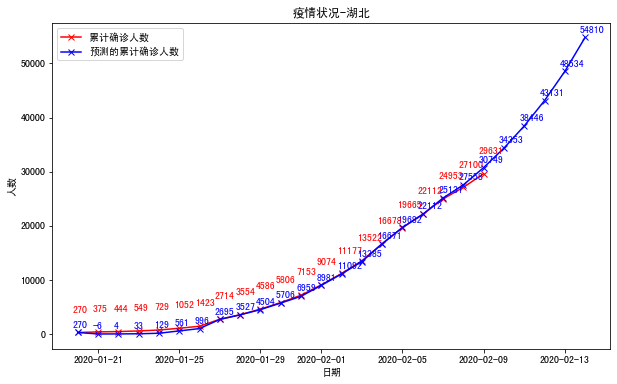

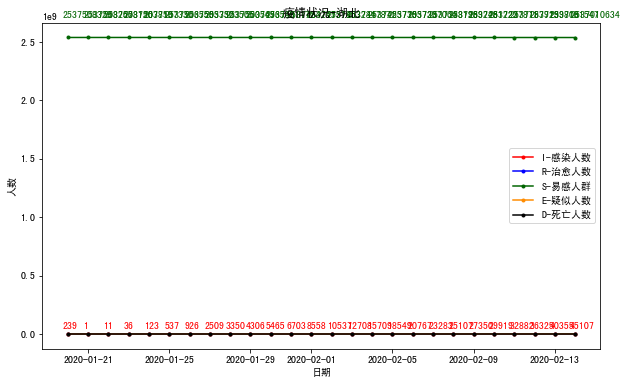

ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

In [41]:
features=['I', 'cured', 'dead','E']
load_model_predict(model_city_date_path, data_hubei, city_name='湖北', features=features)

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171]
new_confirm: [ 149.  131.  259.  457.  688.  769. 1771. 1459. 1737. 1981. 2099. 2589.
 2825. 3233. 3886. 3694. 3143. 3385. 2652. 2973.]
new_confirm_pred: [-2.550e+02  3.000e+00  1.400e+01  3.330e+02  9.860e+02  1.144e+03
  1.892e+03  1.493e+03  1.818e+03  2.032e+03  2.043e+03  2.532e+03
  2.788e+03  3.204e+03  3.975e+03  3.724e+03  3.056e+03  3.415e+03
  2.736e+03  4.145e+03]


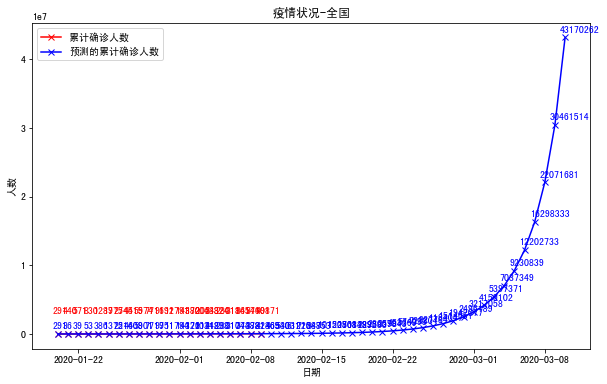

confirm_pred: [     291       36       39       53      386     1372     2516     4408
     5901     7719     9751    11794    14326    17114    20318    24293
    28017    31073    34488    37224    41369    46540    53031    61220
    71588    84753   101507   122868   150138   184992   229583   286679
   359843   453669   574093   728804   927784  1184047  1514651  1942077
  2496189  3217058  4159102  5397371  7037349  9230839 12202733 16298333
 22071681 30461514 43170262]


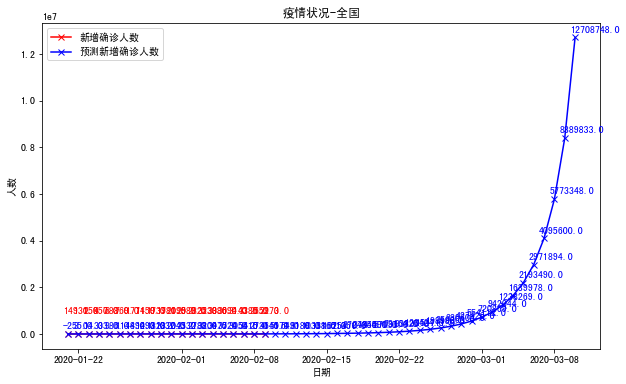

In [153]:
# def load_model_predict(model_city_date_path, data, N_cur,beta,gamma_2,theta, city_name='深圳',c='confirmed', features=['I','cured','dead','E'], pred_date_len=5):
#     I_name,recover_name,dead_name,E_name = features
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)

#     new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
#     print("new_confirm:",new_confirm)
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)
#     print("new_confirm_pred:",new_confirm_pred)


#     # print(I_pred_old+R_pred_old+D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(N_cur=N_cur,beta=beta,gamma_2=gamma_2,theta=theta, pred_date_len = pred_date_len)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
#     print("confirm_pred:",confirm_pred)
#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)
# load_model_predict(model_city_date_path, data_china, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], city_name='全国', features=features, pred_date_len=30)

In [ ]:
merge_data = pd.read_csv('./ncov/data/nation/allcity_20200209.csv')
merge_data = merge_data.rename(columns = {'updatetime':'time'})
merge_data['time'] = merge_data['time'].apply(lambda x: '2020/'+x)
merge_data['time']

In [ ]:
merge_data['I'] = merge_data['confirmed']-merge_data['dead']-merge_data['cured']
merge_data['I']

In [ ]:
merge_data['time']= pd.to_datetime(merge_data['time'])
merge_data['time']

In [ ]:
data_sz = merge_data[merge_data.cityname=='深圳']
data_sz

In [ ]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [ ]:
model_city_date_path = make_dir('shenzhen','02-08')
features=['I', 'cured','dead']
I_init = float(data_sz['I'].iloc[0])
R_init = float(data_sz['cured'].iloc[0])
D_init = float(data_sz['dead'].iloc[0])
N = 13026600.
S,I,E,R,D = train(data_sz, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [ ]:
# def load_model_predict(model_city_date_path, data, city_name='深圳',c='confirmed'):
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


#     new_confirm = cal_new_confirm(np.array(data['I']),np.array(data['cured']),np.array(data['dead']))
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = 5)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=5)

#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=5)

In [ ]:
model_city_date_path = 'models/shenzhen/02-08'

In [ ]:
param = {'beta_model_0': 0.022657147212237192, 'gamma_2_model_0': 0.046245946644636965, 'N_model_0': 13026600.144694937, 'theta_model_0': 0.0017369414764662925}

In [ ]:
load_model_predict(model_city_date_path, data_sz,N_cur=param['N_model_0'],beta=param['beta_model_0'],gamma_2=param['gamma_2_model_0'],theta=param['theta_model_0'], city_name='深圳')

In [ ]:
data_wh = merge_data[merge_data.cityname=='武汉']

In [ ]:
model_city_date_path = make_dir('wuhan','02-08')
features=['I', 'cured','dead']
I_init = float(data_wh['I'].iloc[0])
R_init = float(data_wh['cured'].iloc[0])
D_init = float(data_wh['dead'].iloc[0])
N = 2870000.
S,I,E,R,D = train(data_wh, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [ ]:
model_city_date_path='models/wuhan/02-08'

In [ ]:
param = {'beta_model_1': 0.039265121494126254, 'gamma_2_model_1': 0.012185829495883437, 'N_model_1': 2870000.1178264813, 'theta_model_1': 0.029595901217760776}

In [ ]:
load_model_predict(model_city_date_path, data_wh, N_cur=param['N_model_1'],beta=param['beta_model_1'],gamma_2=param['gamma_2_model_1'],theta=param['theta_model_1'], city_name='武汉')

In [ ]:
param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}
i=2
for k in list(param.keys()):
    old_key = k
    new_key = k.replace(f'_model_{i}','')
    param[new_key]=param.pop(old_key)
param

In [ ]:
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    # if param=={}:
    #     param['N']=0
    #     N_cur=param['N']
    # else:
    #     N_cur=param['N']
    #     beta=param['beta']
    #     gamma_2=param['gamma_2']
    #     theta=param['theta']
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path

In [ ]:
data_hubei = merge_data[(merge_data.provincename=='湖北')&(merge_data.cityname=='全省')]
data_hubei

In [ ]:
param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}


In [ ]:
model_city_date_path = train_with_city_data(data_hubei,59170000.,'02-08','湖北')

In [ ]:
load_model_predict(model_city_date_path, data_hubei, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], city_name='湖北')

In [ ]:
model_city_date_paths = ['models/shenzhen/02-08','models/wuhan/02-08','models/hubei/02-08','models/china/02-08']

In [ ]:
for model_i in range(len(model_city_date_paths)):
    print(model_city_date_paths[model_i]+':{')
    model_city_date_path = model_city_date_paths[model_i]
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    print(f'beta_model_{model_i}:{beta}')
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    print(f'gamma_2_model_{model_i}:{gamma_2}')
    N = []
    for i in range(len(model.SEIR_cells)):
        N.append(model.SEIR_cells[i].N.detach().numpy()[0])
    print(f'N_model_{model_i}:{N}')    
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    print(f'theta_model_{model_i}:{theta}')  
    print('}')

In [ ]:
len(model.SEIR_cells)

In [ ]:
beta_sz = []
for i in range(len(model.SEIR_cells)):
    beta_sz.append(model.SEIR_cells[i].beta.detach().numpy()[0])
beta_sz